In [ ]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Point to insolation_model project root
insolation_root = Path(os.path.dirname(os.path.abspath(""))).resolve()
if str(insolation_root) not in sys.path:
    sys.path.insert(0, str(insolation_root))

import numpy as np

from insolation_model import vis

from insolation_model.geometry.shading import _make_wave_front

from tests.conftest import make_dem_with_gradients

In [ ]:
dx = 1
grad_x = -0.1
grad_y = -0.1
n_rows = 15
n_cols = 5
dem = make_dem_with_gradients(grad_x, grad_y, dx, dx, n_rows, n_cols)
azimuth = 25


Fi, Fj = _make_wave_front(n_rows, n_cols, azimuth)

rows = np.clip(Fi.astype(int), 0, dem.arr.shape[0] - 1)
cols = np.clip(Fj.astype(int), 0, dem.arr.shape[1] - 1)
values = dem.arr[rows, cols]
valid = (Fi >= 0) & (Fj >= 0) & (Fi < n_rows) & (Fj < n_cols)
values[~valid] = 0
cummax = np.maximum.accumulate(values, axis=0)

In [3]:
def plot_indices(I, J, ax, **kwargs):
    return ax.scatter(J + 0.5, -I - 0.5, **kwargs)

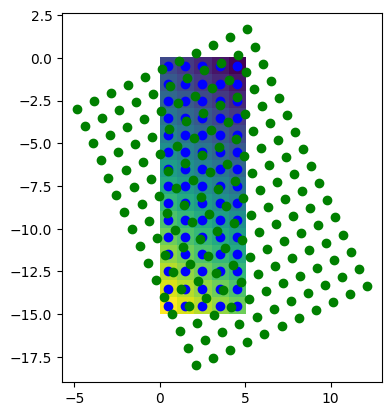

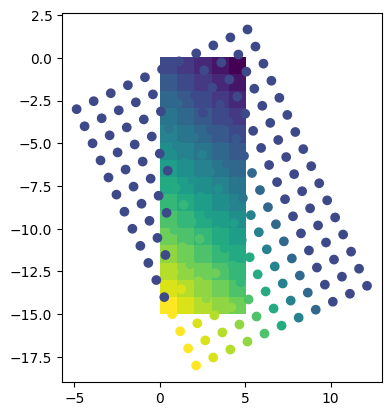

In [4]:
J, I = np.meshgrid(
    np.linspace(0, n_cols - 1, n_cols), np.linspace(0, n_rows - 1, n_rows)
)
vmin, vmax = dem.arr.min(), dem.arr.max()


ax = vis.raster(dem)
plot_indices(I, J, ax, color="blue")


for ii, jj in zip(Fi, Fj):
    plot_indices(ii, jj, ax, color="green")
plt.show()

ax = vis.raster(dem, vmin=vmin, vmax=vmax)
# plot_indices(I, J, ax, color="blue")
plot_indices(Fi, Fj, ax, c=cummax, vmin=vmin, vmax=vmax)
plt.show()